# Assignment 1

Burning forest analysis and simulation.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage.measurements
from matplotlib import animation, rc, colors
import imageio

In [4]:
class Forest:
    
    # states: 0 - empty, 1 - tree, 2 - burning tree, 3 - burned tree
    
    def __init__(self, L = 10, p = 0.5):
        self.L = L
        self.p = p
        self.lattice = (np.random.rand(L,L) < p) * 1
        self.burning_forest = None
        self.previous_step = None
        
    def set_on_fire(self, edge = 1, neighborhood = np.array([[1,1,1],
                                                             [1,1,1],
                                                             [1,1,1]])):
        # edge: 1 - bottom, 2 - right, 3 - upper, 4/other - left
        self.fire = np.zeros([self.L,self.L])
        if edge == 1:
            self.fire[-1,:] = 1
        elif edge == 2:
            self.fire[:,-1] = 1
        elif edge == 3:
            self.fire[0,:] = 1
        else:
            self.fire[:,0] = 1
        self.previous_step = self.lattice
        self.burning_forest = ((self.fire + self.lattice) == 2) + self.lattice # initialize a fire on a choosen edge
        
        self.coord = np.array([[(-1,-1), (-1,0), (-1,1)],
                               [(0,-1), (0,0), (0,1)],
                               [(1,-1), (1,0), (1,1)]])

        self.coord = self.coord[neighborhood==1]  # setting a type of neighborhood for spreading fire
        self.end = False
        
        
    def burn_one_step(self): 
        # it can run while there is "2" at the burning_forest lattice, and burning_forest exists, and is different 
        # from previous step
                
        if (self.burning_forest is not None) & (~np.all(self.burning_forest == self.previous_step)):
            self.previous_step = self.burning_forest.copy()
            
            if np.any(self.previous_step == 2):
                rows, cols = np.where(self.previous_step == 2) # which trees are burning
                loc = np.array([rows, cols]).transpose()
                neighbors = [(loc_i + self.coord).tolist() for loc_i in loc] # getting their neighbors
                neighbors = np.unique(np.array([item for sublist in neighbors for item in sublist]), axis=0)
                neighbors = neighbors[np.all((neighbors < self.L) & (neighbors >= 0), axis=1),:]
                neighbors_grid = np.zeros([self.L,self.L])
                neighbors_grid[neighbors.T.tolist()] = 1 # pointing neighbors on a grid
                  
                self.burning_forest[self.burning_forest == 2] = 3 # changing burning trees to burned ones
                self.burning_forest[(self.burning_forest == neighbors_grid) & (neighbors_grid == 1)] = 2 # burning neighbors
            else:
                self.end = True # fire ended
        else:
            self.end = True # no fire
            
    def burn(self):
        while (self.end == False):
            self.burn_one_step()

Just to look how the object works...

In [5]:
my_forest = Forest(p=0.5, L=10)
my_forest.lattice

array([[0, 1, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 1, 1, 1, 0, 0],
       [1, 1, 0, 1, 1, 0, 1, 0, 1, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
       [0, 0, 1, 1, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 1, 1, 0, 1, 0, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 1, 1, 0, 1, 1]])

In [7]:
my_forest.set_on_fire(2)

In [146]:
my_forest.burn_one_step()

In [147]:
my_forest.burning_forest

array([[1, 1, 1, 1, 0, 0, 0, 0, 2, 3],
       [1, 1, 0, 1, 1, 0, 0, 0, 0, 3],
       [1, 1, 1, 1, 0, 1, 0, 0, 2, 3],
       [1, 0, 0, 1, 1, 0, 0, 1, 2, 0],
       [1, 1, 1, 1, 0, 0, 0, 1, 2, 3],
       [1, 0, 0, 1, 1, 1, 0, 1, 2, 3],
       [0, 1, 0, 1, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 1, 0, 3],
       [1, 0, 0, 1, 1, 1, 0, 1, 0, 3],
       [1, 1, 1, 1, 0, 0, 1, 0, 0, 3]])

#### Find the so called percolation threshold p*, i.e. the probability that fire hits the opposite edge of the grid during the simulation. Use L = 20, 50 and 100 for the linear size of the lattice. Plot the average size of the biggest cluster of burned threes as a function of p for L = 100.

In [3]:
def analyze_forest(L, fire_neighborhood, cluster_neighborhood):
    percolation= []
    biggest_cluster_size = []
    for p in np.linspace(0,1,50):
        prob = []
        cluster_size = []
        for i in range(20):
            my_forest = Forest(L, p)
            my_forest.set_on_fire(4, neighborhood = fire_neighborhood)
            my_forest.burn()
            prob.append(1 if np.any(my_forest.burning_forest[:,L-1] == 3) else 0)
            clustering = scipy.ndimage.measurements.label(my_forest.burning_forest == np.ones([L,L])*3, structure = cluster_neighborhood)[0]
            clusters, freq = np.unique(clustering, return_counts=True)
            cluster_size.append( 0 if np.any(clusters) == 0 else (freq.max() if clusters[freq.argmax()] != 0 else np.sort(freq)[-2]) )
    
        percolation.append(np.mean(prob))
        biggest_cluster_size.append(np.mean(cluster_size))
    
    return percolation, biggest_cluster_size

In [7]:
cluster_neighborhood = [[1,1,1],
                        [1,1,1],
                        [1,1,1]]

cluster_neighborhood_Neuman = [[0,1,0],
                               [1,1,1],
                               [0,1,0]]

fire_neighborhood_Neuman = np.array([[0,1,0],
                                     [1,1,1],
                                     [0,1,0]])

fire_neighborhood_Moore = np.array([[1,1,1],
                                    [1,1,1],
                                    [1,1,1]])

In [14]:
percolation20_Neuman, cluster20_Neuman = analyze_forest(20, fire_neighborhood_Neuman, cluster_neighborhood)
percolation50_Neuman, cluster50_Neuman = analyze_forest(50, fire_neighborhood_Neuman, cluster_neighborhood)
percolation100_Neuman, cluster100_Neuman = analyze_forest(100, fire_neighborhood_Neuman, cluster_neighborhood)

In [15]:
percolation20_Moore, cluster20_Moore = analyze_forest(20, fire_neighborhood_Moore, cluster_neighborhood)
percolation50_Moore, cluster50_Moore = analyze_forest(50, fire_neighborhood_Moore, cluster_neighborhood)
percolation100_Moore, cluster100_Moore = analyze_forest(100, fire_neighborhood_Moore, cluster_neighborhood)

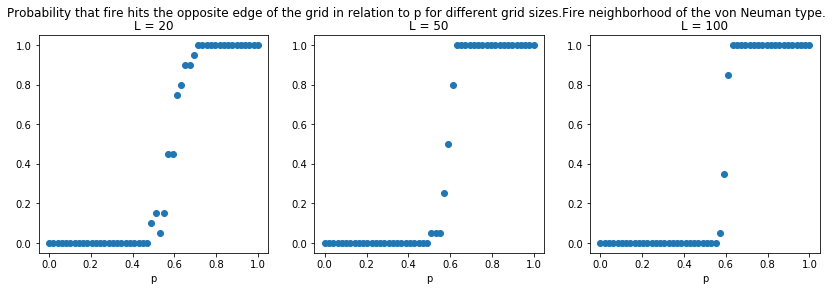

In [25]:
fig = plt.figure(figsize=(14,4))
fig.suptitle('Probability that fire hits the opposite edge of the grid in relation to p. Fire neighborhood of the von Neuman type.', fontsize=12)
plt.subplot(131)
plt.plot(np.linspace(0,1,50), percolation20_Neuman, 'o')
plt.xlabel('p')
plt.title('L = 20')
plt.subplot(132)
plt.plot(np.linspace(0,1,50), percolation50_Neuman, 'o')
plt.xlabel('p')
plt.title('L = 50')
plt.subplot(133)
plt.plot(np.linspace(0,1,50), percolation100_Neuman, 'o')
plt.xlabel('p')
plt.title('L = 100')
plt.show()

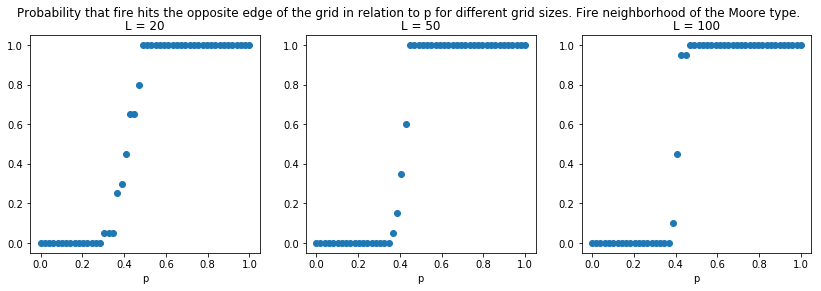

In [26]:
fig = plt.figure(figsize=(14,4))
fig.suptitle('Probability that fire hits the opposite edge of the grid in relation to p. Fire neighborhood of the Moore type.', fontsize=12)
plt.subplot(131)
plt.plot(np.linspace(0,1,50), percolation20_Moore, 'o')
plt.xlabel('p')
plt.title('L = 20')
plt.subplot(132)
plt.plot(np.linspace(0,1,50), percolation50_Moore, 'o')
plt.xlabel('p')
plt.title('L = 50')
plt.subplot(133)
plt.plot(np.linspace(0,1,50), percolation100_Moore, 'o')
plt.xlabel('p')
plt.title('L = 100')
plt.show()

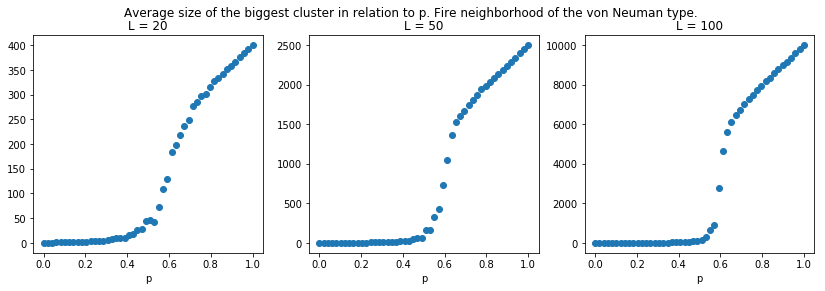

In [27]:
fig = plt.figure(figsize=(14,4))
fig.suptitle('Average size of the biggest cluster in relation to p. Fire neighborhood of the von Neuman type.', fontsize=12)
plt.subplot(131)
plt.plot(np.linspace(0,1,50), cluster20_Neuman, 'o')
plt.xlabel('p')
plt.title('L = 20')
plt.subplot(132)
plt.plot(np.linspace(0,1,50), cluster50_Neuman, 'o')
plt.xlabel('p')
plt.title('L = 50')
plt.subplot(133)
plt.plot(np.linspace(0,1,50), cluster100_Neuman, 'o')
plt.xlabel('p')
plt.title('L = 100')
plt.show()

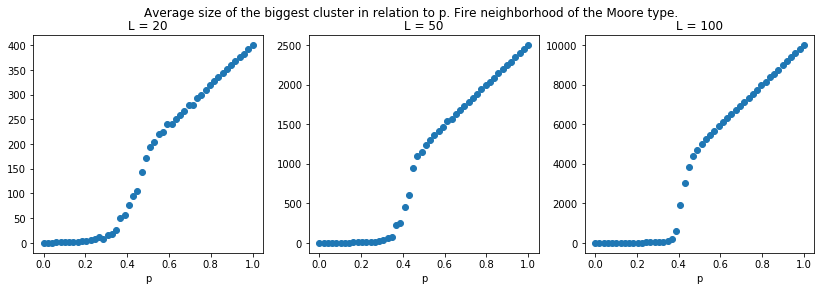

In [28]:
fig = plt.figure(figsize=(14,4))
fig.suptitle('Average size of the biggest cluster in relation to p. Fire neighborhood of the Moore type.', fontsize=12)
plt.subplot(131)
plt.plot(np.linspace(0,1,50), cluster20_Moore, 'o')
plt.xlabel('p')
plt.title('L = 20')
plt.subplot(132)
plt.plot(np.linspace(0,1,50), cluster50_Moore, 'o')
plt.xlabel('p')
plt.title('L = 50')
plt.subplot(133)
plt.plot(np.linspace(0,1,50), cluster100_Moore, 'o')
plt.xlabel('p')
plt.title('L = 100')
plt.show()

To compare how clustering looks like for von Neuman clustering neighborhood:

In [5]:
percolation20_Moore1, cluster20_Moore1 = analyze_forest(20, fire_neighborhood_Moore, cluster_neighborhood_Neuman)
percolation50_Moore1, cluster50_Moore1 = analyze_forest(50, fire_neighborhood_Moore, cluster_neighborhood_Neuman)
percolation100_Moore1, cluster100_Moore1 = analyze_forest(100, fire_neighborhood_Moore, cluster_neighborhood_Neuman)

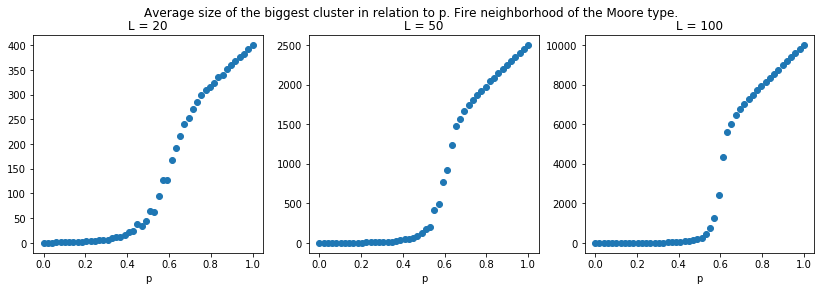

In [6]:
fig = plt.figure(figsize=(14,4))
fig.suptitle('Average size of the biggest cluster in relation to p. Fire neighborhood of the Moore type.', fontsize=12)
plt.subplot(131)
plt.plot(np.linspace(0,1,50), cluster20_Moore1, 'o')
plt.xlabel('p')
plt.title('L = 20')
plt.subplot(132)
plt.plot(np.linspace(0,1,50), cluster50_Moore1, 'o')
plt.xlabel('p')
plt.title('L = 50')
plt.subplot(133)
plt.plot(np.linspace(0,1,50), cluster100_Moore1, 'o')
plt.xlabel('p')
plt.title('L = 100')
plt.show()

#### GIF

In [5]:
def animate(L, p, edge, neighborhood):
    gif_path = "burning_forest_simulation.gif"
    frames_path = "frames/{i}.jpg"
    
    if np.all(neighborhood == np.array([[0,1,0],[1,1,1],[0,1,0]])):
        t = 'von Neuman'
    else:
        t = 'Moore'

    cmap = colors.ListedColormap([(80/255,50/255,0), 'green', 'red', 'k'])
    bounds = [0,1,2,3]
    norm = colors.BoundaryNorm(bounds, 3)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.grid()
    ax.set_title('Forest of size L = {L}, afforestation p = {p} and fire neighborhood of type {t}'.format(L=L, p=p, t=t))

    my_forest = Forest(L, p)
    im = ax.imshow(my_forest.lattice, cmap=cmap, norm=norm)
    plt.savefig("frames/0.jpg")
    my_forest.set_on_fire(edge, neighborhood)
    im.set_array(my_forest.burning_forest)
    plt.savefig("frames/1.jpg")

    n = 2
    while (my_forest.end == False):
        my_forest.burn_one_step()
        im.set_array(my_forest.burning_forest)
        plt.savefig("frames/{i}.jpg".format(i=n))
        n += 1

    with imageio.get_writer(gif_path, mode='I') as writer:
        for i in range(n):
            writer.append_data(imageio.imread(frames_path.format(i=i)))


In [10]:
animate(60, 0.6, 1, fire_neighborhood_Moore)

In [11]:
animate(60, 0.6, 1, fire_neighborhood_Neuman)